# FMCW Radar 102 - CFAR

CFAR stands for `Constant False Alarm Rate` and is the generic name for detecting target in a noisy/ uncertain environment.

Goal:

> Explicit in one single place code and maths needed to understand CFAR for FMCW radar.

Status:

* this work book runs in any browser and correctly computes CFAR for a multi target in a AWGN noisy environment

Howto:

> you can start with the maths or with the code, you should finish the otherway round and check they both match.

1. if needed check the introduction to Google Colab to run notebooks in your web browser [here](https://colab.research.google.com/)

2. Navigate to the cell `CFAR code` and execute it
3. Then navigate to the cell `Visual CFAR experiment` and run it a few times until you `see` more peaks than you have in code (i.e. some noise spikes out)
4. Then navigate to the cell `CFAR code` and run it, you should see the peaks highlighted.
5. you can now change the pfa, training, guard values to see the impact on the CFAR output.

History:

* 2022-Dec-15: Clean-up to have MRE for CFAR as standalone cells
* 2022-Apr-28: creation



Next:

* click to access other workbooks:
  * [FMCW 102 - CFAR](https://colab.research.google.com/gist/matt-chv/33e98a23d4b9d90dd27c1bf7f0a54781/fmcw-radar-102-cfar.ipynb) : CFAR or how to detect objects of interest from range FFT.
  * [FMCW 103 - AoA](https://colab.research.google.com/gist/matt-chv/d81f7e2166009a623a36781a0773ae47/fmcw-radar-103-aoa.ipynb) : angle of arrival (CAPON vs Bartlett)
  * [FMCW 104 - increased resolution vs FFT bin](https://colab.research.google.com/gist/matt-chv/0b25dbc4673f2d7d63804cc6241643b9/fmcw-radar-104-1-fft-freq-estimation.ipynb)increase accuracy option compared to standard FFT.
  * Also available on github as gist for forking:
    * [fmcw 101](https://gist.github.com/matt-chv/bdd8b835c5cb7e739bb8b68d00257690)
    * [fmcw 102](https://gist.github.com/matt-chv/33e98a23d4b9d90dd27c1bf7f0a54781)
    * ...

Related ressources:

* Eq 6 and Eq 7 corrected for typo from [1][Analysis of the CA CFAR Algorithm as Applied to
Detection of Stationary Gaussian Signals
Against a Normal Noise Background]

1: [Analysis of the CA CFAR Algorithm as Applied to
Detection of Stationary Gaussian Signals
Against a Normal Noise Background][Analysis of the CA CFAR Algorithm as Applied to
Detection of Stationary Gaussian Signals
Against a Normal Noise Background]


[Analysis of the CA CFAR Algorithm as Applied to
Detection of Stationary Gaussian Signals
Against a Normal Noise Background]: https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7538162

Possible addition:
* https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.634.6916&rep=rep1&type=pdf
* https://www.irjet.net/archives/V5/i7/IRJET-V5I7431.pdf
* https://www.riverpublishers.com/pdf/ebook/chapter/RP_9788793519138C07.pdf

mmWave code:
c:\ti\mmwave_sdk_03_05_00_04\packages\ti\alg\mmwavelib\src\detection\mmwavelib_cfarca.c

> code seems to mostly compare cell value to background, no CFAR.

###  CFAR maths

At the high-level CFAR is about computing a threshold so that the probability of false positive is below a given threshold aka `pfa`.

### Generic intro
A simplified way to look at it is to consider a `AWGN` where any threshold can be compared to the variance and yield a probability of false positive, see the [quantile funciton of a gaussian](https://en.wikipedia.org/wiki/Normal_distribution#Quantile_function).

### Application to FMCW radar

To apply this to radar, one needs to consider if the noise is:

* Gaussian
* non-gaussian (and which type)
...

Assuming here that the noise is gaussian, the Noise Floor `NF` needs to be estimated.

For this the average of the power in bins surounding the bin under test will be calculated.

To avoid biasing the average with spectrum leakage a certain number of `guard bins` are excluded from `NF` estimate.

Once the `NF` is estimated, a certain threshold is computed and if above the threshold then the bin is considered to hold a valid peak value.

### Illustration

![](https://farm2.staticflickr.com/1652/25170561054_2e4c18a434_z.jpg)

$$ P_{fa} = \left[ \frac{M}{T+M} \right]^M $$
Where:
* $ P_{fa} $ is the probability false alarm
* T CA-CFAR threshold
* M length of train sequence

Which is equivalent to

$$ T = M \cdot (P_{fa}^{-1/M}-1) $$



## CFAR code

In [ ]:
# run this cell to do all imports and define the ca_cfar function
from numpy import angle, arange, abs, cos, pi, random
# from np.random import normal
from scipy.fft import fft
import matplotlib.pyplot as plt

from numpy import sqrt
def ca_cfar_new(X,count_train_cells = 100,count_guard_cells=1, Pfa=0.1,return_threshold = False):
    """ Retuns indexs of peaks found via CA-CFAR
    i.e Cell Averaging Constant False Alarm Rate algorithm
    Parameters:
    -----------
    X: numpy array
      signal whose peaks have to be detected and reported
    count_train_cells: int
      number of cells used to train CA-CFAR
    count_guard_cells: int
      number of cells guarding CUT against noise power calculation
    Pfa: float
      Probability of false alert, used to compute the variable threshold for peak
    Returns:
    --------
    peak_locations: numpy array
      list of indexes where CA-CFAR found a peak
    """
    signal_length = X.size
    M = count_train_cells
    half_M = round(M / 2)
    count_leading_guard_cells = round(count_guard_cells / 2)
    half_window_size = half_M + count_leading_guard_cells
    # compute power of signal
    P = [x**2 for x in X]
    #P = X #[x for x in X]

    #T scaling factor for threshold
    #from Eq 6, Eq 7 from [1]
    #T = M*(Pfa**(-1/M) - 1)**M
    T = M*(Pfa**(-1/M) - 1)

    peak_locations = []
    thresholds = [0]*(half_window_size)
    for i in range(half_window_size,signal_length-half_window_size):
        p_noise = np.sum(P[i-half_M:i+half_M+1])
        p_noise -= np.sum(P[i-count_leading_guard_cells:i+count_leading_guard_cells+1])
        p_noise = p_noise/M
        threshold = T * p_noise
        thresholds.append(sqrt(threshold))
        if P[i] > threshold:
            peak_locations.append(i)
    peak_locations = np.array(peak_locations, dtype=int)
    if return_threshold:
      return np.array(thresholds + [0]*(half_window_size))
    else:
      return np.array(peak_locations)


## Visual CFAR experiment

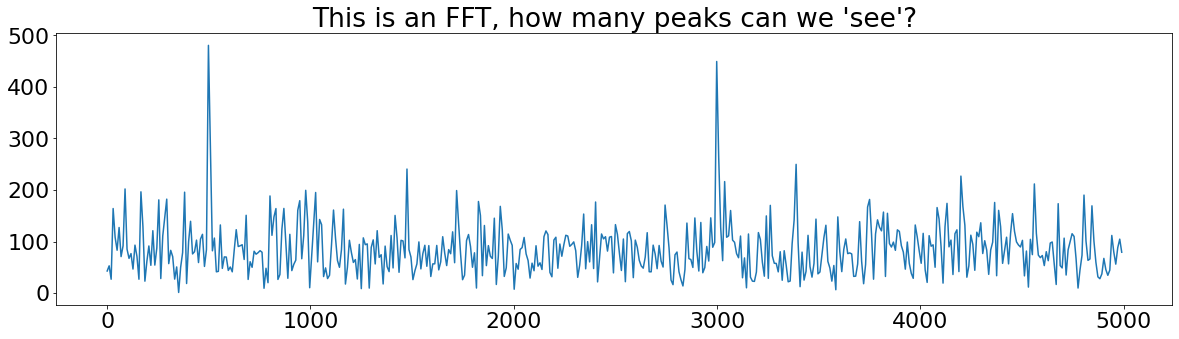

In [ ]:
# run this cell to have an example FFT

# This code defines 2 sine waves in a noisy environment and plots it
# how easy is it after a few runs when noise peaks are high to see which is a
# peak and which is noise?

f0, f1 = 0.5e3, 3e3
fs = 10e3
n_samples = 1024
T = arange(0, n_samples*1/fs, 1/fs)
Y = cos(2*pi*(f0*T)) + cos(2*pi*f1*T) + random.normal(0,3,n_samples)
FT = fft(Y)
F = [i*fs/n_samples for i in range(len(T))]
F = np.array(F[0:int(n_samples/2)])
MAG = abs(FT[0:int(n_samples/2)])
plt.title("This is an FFT, how many peaks can we 'see'?")
plt.plot(F,MAG )

## CFAR code

Text(0, 0.5, 'FFT Amplitude')

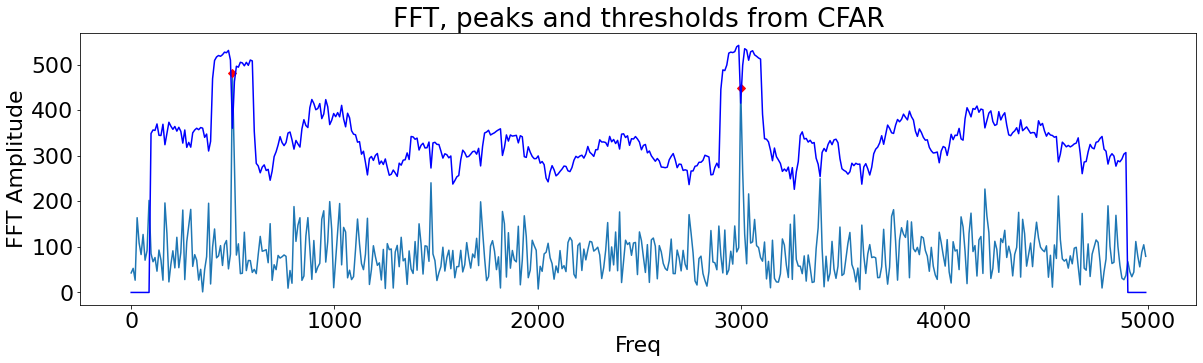

In [ ]:
# run this cell to see CFAR in action and how tweaking parameters changes output
# here we define the number of training cells
train = 20
# the number of guard cells
# which is to account for spectral leakage
# or if a bin has an adjacent bin with energy (because frequency is not perfectly in one bin)
guard = 1
# the proability of false error
# to be noted the lower the pfa, the higher the false negatives probability...
pfa = 0.0001

# get the index of the position of peaks
peak_idx = ca_cfar_new(MAG, train, guard, pfa)
# get the computed thresholds to be able to plot them
th = ca_cfar_new(MAG, train, guard, pfa, return_threshold = True)

# plot the FFT
plt.plot(F,MAG)
# mark the peaks
plt.plot(F[peak_idx], MAG[peak_idx], 'rD')
# show the thresholds computed (you can change, train, guard or pfa to see changes)
# lower # train cells will under-estimate the noise floor and will yield to more
# false positives
# higher pfa will also increase the number of peaks
plt.title("FFT, peaks and thresholds from CFAR")
plt.plot(F,th,'b-')
plt.xlabel('Freq')
plt.ylabel('FFT Amplitude')

## BACK-up content
do not read beyond this point, this is either noise or incorrect

## CFAR



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Plot settings
plt.rcParams['figure.figsize'] = (20, 5) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams.update({'font.size': 22})

def ca_cfar_new(X,count_train_cells,count_guard_cells, Pfa,return_threshold = False):
    """ Retuns indexs of peaks found via CA-CFAR
    i.e Cell Averaging Constant False Alarm Rate algorithm
    Parameters:
    -----------
    X: numpy array
      signal whose peaks have to be detected and reported
    count_train_cells: int
      number of cells used to train CA-CFAR
    count_guard_cells: int
      number of cells guarding CUT against noise power calculation
    Pfa: float
      Probability of false alert, used to compute the variable threshold for peak
    Returns:
    --------
    peak_locations: numpy array
      list of indexes where CA-CFAR found a peak
    """
    signal_length = X.size
    M = count_train_cells
    half_M = round(M / 2)
    count_leading_guard_cells = round(count_guard_cells / 2)
    half_window_size = half_M + count_leading_guard_cells
    # compute power of signal
    #P = [x**2 for x in X]
    P = X #[x for x in X]

    #T scaling factor for threshold
    #from Eq 6, Eq 7 from [1]
    #T = M*(Pfa**(-1/M) - 1)**M
    T = M*(Pfa**(-1/M) - 1)
    print("Pfa**(-1/M",Pfa**(-1/M))
    print("T T",T)

    peak_locations = []
    thresholds = []
    for i in range(half_window_size,signal_length-half_window_size):

        #if i != i-half_window_size + np.argmax(P[i-half_window_size:i+half_window_size+1]):
        #    continue
        p_noise = np.sum(P[i-half_M:i+half_M+1])- \
          np.sum(P[i-count_leading_guard_cells:i+count_leading_guard_cells+1])
        p_noise = p_noise/M
        threshold = T * p_noise #*1.5

        thresholds.append(threshold)
        if P[i] > threshold:
            peak_locations.append(i)

    peak_locations = np.array(peak_locations, dtype=int)

    if return_threshold:
      return np.array(thresholds )
    else:
      return peak_locations

def ca_cfar_old(x, num_train, num_guard, rate_fa):
    """ Detect peaks with CA-CFAR algorithm (Cell Averaging CFAR).
    credit: http://tsaith.github.io/detect-peaks-with-cfar-algorithm.html
    FIXME: need to work with rate_fa < 0.3

    num_train: int
      Number of training cells.
    num_guard: int
      Number of guard cells.
    rate_fa: float
      False alarm rate.
    """
    num_cells = x.size
    num_train_half = round(num_train / 2)
    num_guard_half = round(num_guard / 2)
    num_side = num_train_half + num_guard_half

    #fIXME where does it come from?
    alpha = num_train*(rate_fa**(-1/num_train) - 1) # threshold factor
    #alpha = num_train*(rate_fa**(-1/num_train) - 1)**num_train

    peak_idx = []
    for i in range(num_side, num_cells - num_side):

        if i != i-num_side+np.argmax(x[i-num_side:i+num_side+1]):
            continue

        sum1 = np.sum(x[i-num_side:i+num_side+1])
        sum2 = np.sum(x[i-num_guard_half:i+num_guard_half+1])
        p_noise = (sum1 - sum2) / num_train
        threshold = alpha * p_noise
        print("i old ",i,x[i],threshold)

        if x[i] > threshold:
            peak_idx.append(i)


    peak_idx = np.array(peak_idx, dtype=int)

    return peak_idx


Pfa**(-1/M 1.2589254117941673
T T 2.589254117941673
Pfa**(-1/M 1.2589254117941673
T T 2.589254117941673
peak_idx = [ 8  9 11 20 21 23 25 27 32 33 39 40 45 51 52 53 54 63 68 73 74 79 80 86
 88]
N peaks 25
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


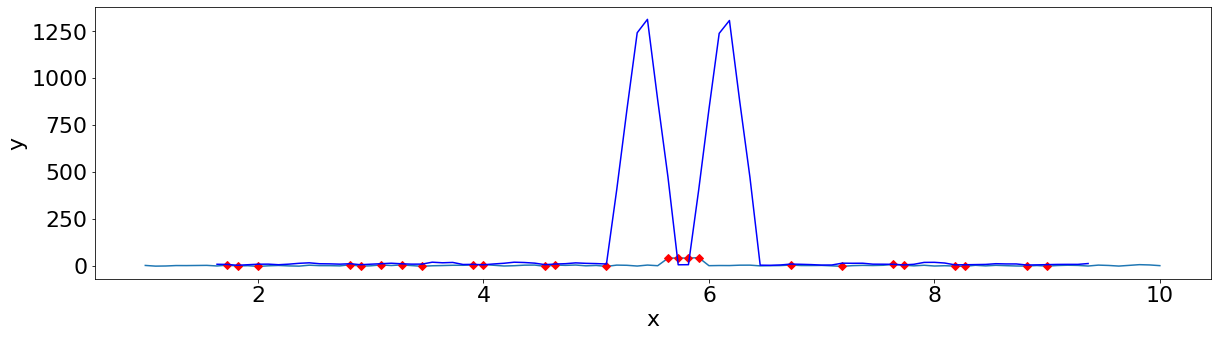

In [ ]:
from numpy import sinc,sin
min=1
max=10
step = 1/10
x=np.linspace(min,max,int(max/step))
#y = 1+sinc(2*np.pi*(x-2))+0.3*sinc(2*np.pi*(x-4))
#y = 10/x + 5*sinc(2*np.pi*(x-5))+0.3*sinc(2*np.pi*(x-10))
y2 = 2*np.random.randn(x.size)
#y2[0:50]+=3
y2[51:55]+=40
#y2[40]+=10
#y2[55]+=5
target_width = 1
peak_idx = None
m_left=5*int(target_width)
g_left=2*int(target_width)
pfa=0.1
#peak_idx = ca_cfar_old(y, 10,2, 0.1)
#peak_idx = ca_cfar_old(y, 30,10, 0.001)
#peak_idx = ca_cfar_old(y, 50,5, 0.4)
peak_idx = ca_cfar_new(y2, m_left*2,g_left*2, pfa)
th = ca_cfar_new(y2, m_left*2,g_left*2,pfa,return_threshold = True)

print("peak_idx =", peak_idx)
print("N peaks", len(peak_idx))

plt.plot(x, y2)
plt.plot(x[peak_idx], y2[peak_idx], 'rD')
plt.plot(x[m_left+g_left:x.size-m_left-g_left],th,'b-')
plt.xlabel('x')
plt.ylabel('y')
print(type(x),type(y2),type(peak_idx))

i old  9 2.549061111267309 2.1825051596837315
i old  50 2.7573757294583254 2.1513247107859543
i old  89 2.6390512031283326 2.2271848758385175
i old  131 2.8238259828129024 2.0433724439492904
i old  169 2.6650188361429272 2.1890637984695034
i old  188 0.9104662721029282 0.552004528851544
peak_idx2 = [  9  50  89 131 169 188]


Text(0, 0.5, 'y')

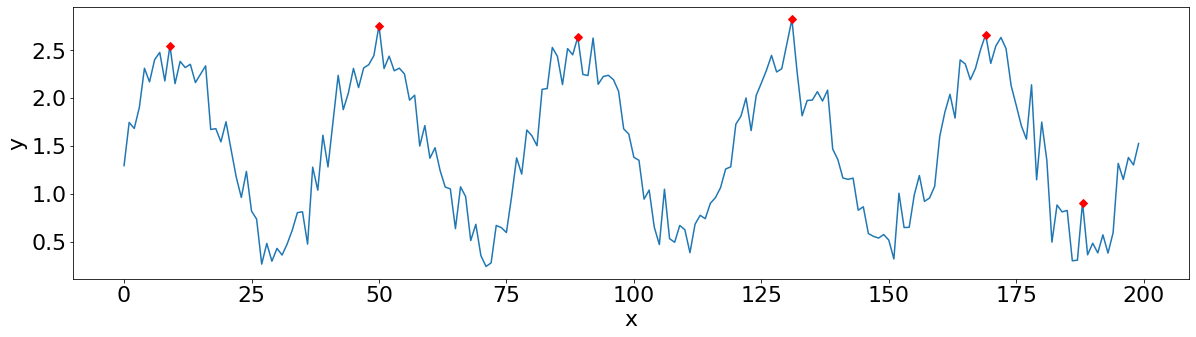

In [ ]:
noise_crest_factor = 0.2
y2 = 1.5+np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + \
      np.random.randn(200)*noise_crest_factor
x2 = np.arange(y.size)

# Detect peaks
# Warning this works only if rate_fa>=0.3
# FIXME: if noise_crest_factor = 0, rate_fa needs to be > 0.5 ?!?!
#peak_idx = ca_cfar(y, num_train=10, num_guard=2, rate_fa=0.1)
peak_idx2 = ca_cfar_old(y2, 10,2, 0.4)
print("peak_idx2 =", peak_idx2)

plt.plot(x2, y2)
plt.plot(x2[peak_idx2], y2[peak_idx2], 'rD')
plt.xlabel('x')
plt.ylabel('y')